### Double Moving Average (DMA) 

1. 安装依赖（只需跑一次）

%pip -q install yfinance pandas numpy matplotlib


2. 导入库

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

3. 下载 Yahoo Finance 数据

In [ ]:
ticker = "XUS.TO"          # 改成 "VFV.TO" / "XIU.TO" / "QQQ" 等
start  = "2018-01-01"
end    = None           # None 表示到今天

df = yf.download(ticker, start=start, end=end, interval="1d", auto_adjust=False, progress=False)

# flatten MultiIndex columns (remove ticker index)
df.columns = df.columns.get_level_values(0)
df = df.dropna(subset=["Close"]).copy()

display(df.tail())
print(df.columns)

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2026-01-05,58.610001,58.610001,58.730000,58.560001,58.560001,129100
2026-01-06,59.180000,59.180000,59.189999,58.660000,58.700001,118300
2026-01-07,59.160000,59.160000,59.430000,59.099998,59.200001,131800
2026-01-08,59.200001,59.200001,59.320000,59.000000,59.200001,133700
2026-01-09,59.810001,59.810001,59.900002,59.360001,59.450001,139100


Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


4. 写一个双均线回测函数（核心）- 特点（研究用、简单好改）：

 - 信号：SMA_fast > SMA_slow 持有，否则空仓

 - 避免未来函数：信号 shift(1)，从下一天才生效

 - 手续费：用 bps 简化（每次换仓扣费）

In [23]:
def max_drawdown(equity: pd.Series) -> float:
    peak = equity.cummax()
    dd = equity / peak - 1.0
    return float(dd.min())  # 返回负数，例如 -0.25 = -25%

def sma_crossover_backtest(
    df: pd.DataFrame,
    fast: int = 10,
    slow: int = 30,
    initial_cash: float = 100000.0,
    fee_bps: float = 10.0,  # 10 bps = 0.10% 每次换仓
):
    data = df.copy()

    data["sma_fast"] = data["Close"].rolling(fast).mean()
    data["sma_slow"] = data["Close"].rolling(slow).mean()

    # 原始信号：fast>slow -> 1，否则 0
    data["signal_raw"] = (data["sma_fast"] > data["sma_slow"]).astype(int)

    # 仓位：用昨天的信号（避免未来函数）
    data["position"] = data["signal_raw"].shift(1).fillna(0).astype(int)

    # 标的收益
    data["asset_ret"] = data["Close"].pct_change().fillna(0.0)

    # 策略毛收益
    data["gross_ret"] = data["position"] * data["asset_ret"]

    # 换仓（0->1 或 1->0）
    data["turnover"] = data["position"].diff().abs().fillna(0.0)

    # 手续费：按“换仓当日”扣（简化为收益层面扣减）
    fee_rate = fee_bps / 10000.0
    data["fee"] = data["turnover"] * fee_rate

    data["net_ret"] = data["gross_ret"] - data["fee"]

    # 净值曲线
    data["equity"] = initial_cash * (1 + data["net_ret"]).cumprod()

    # 指标
    total_return = data["equity"].iloc[-1] / data["equity"].iloc[0] - 1
    mdd = max_drawdown(data["equity"])  # 负数
    trades = int((data["turnover"] > 0).sum())

    # 年化（近似，日频252）
    ann_ret = (1 + data["net_ret"].mean()) ** 252 - 1
    ann_vol = data["net_ret"].std(ddof=0) * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 1e-12 else np.nan

    summary = {
        "fast": fast,
        "slow": slow,
        "initial_cash": initial_cash,
        "final_equity": float(data["equity"].iloc[-1]),
        "total_return_%": float(total_return * 100),
        "max_drawdown_%": float(mdd * 100),
        "annual_return_%": float(ann_ret * 100),
        "annual_vol_%": float(ann_vol * 100),
        "sharpe": float(sharpe),
        "trades": trades,
    }

    return data, summary


5. 跑回测（改 fast/slow 就能换策略参数）

In [24]:
fast = 20
slow = 60
initial_cash = 100000
fee_bps = 10  # 0.10% per trade

bt, summary = sma_crossover_backtest(df, fast=fast, slow=slow, initial_cash=initial_cash, fee_bps=fee_bps)
summary


{'fast': 20,
 'slow': 60,
 'initial_cash': 100000,
 'final_equity': 177259.67229261433,
 'total_return_%': 77.25967229261433,
 'max_drawdown_%': -23.55381265979064,
 'annual_return_%': 8.093388938951973,
 'annual_vol_%': 11.118133097964824,
 'sharpe': 0.7279449587119504,
 'trades': 32}

6. 输出更好看的 summary

In [25]:
pd.Series(summary).to_frame("value")

,value
fast,20.000000
slow,60.000000
initial_cash,100000.000000
final_equity,177259.672293
total_return_%,77.259672
max_drawdown_%,-23.553813
annual_return_%,8.093389
annual_vol_%,11.118133
sharpe,0.727945
trades,32.000000


7. 画图：价格 + 均线 + 仓位 + 净值

<Figure size 640x480 with 0 Axes>

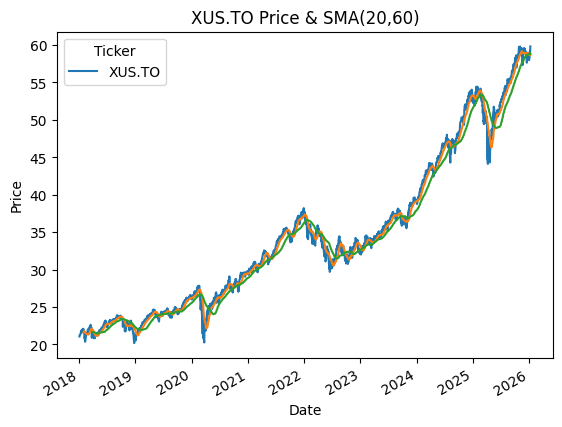

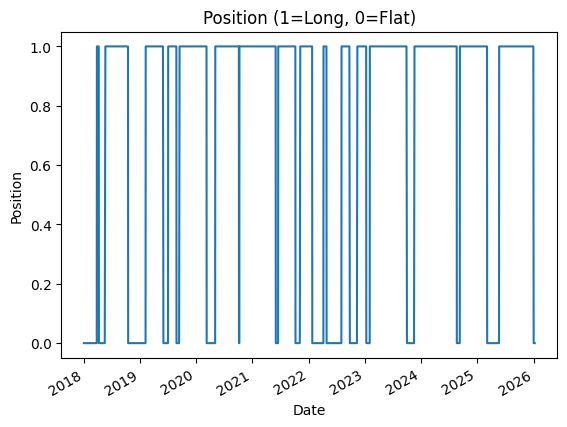

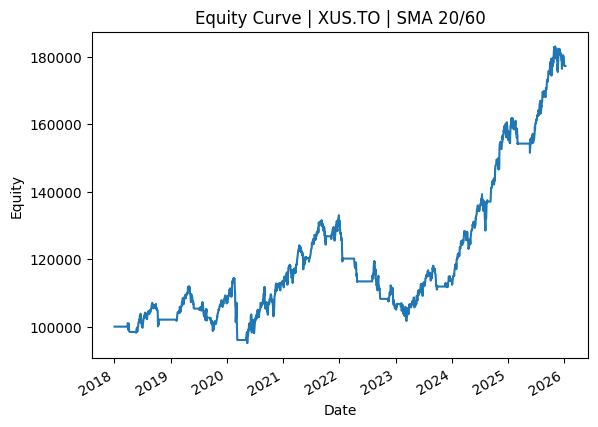

In [26]:
plt.figure()
bt["Close"].plot()
bt["sma_fast"].plot()
bt["sma_slow"].plot()
plt.title(f"{ticker} Price & SMA({fast},{slow})")
plt.xlabel("Date"); plt.ylabel("Price")
plt.show()

plt.figure()
bt["position"].plot()
plt.title("Position (1=Long, 0=Flat)")
plt.xlabel("Date"); plt.ylabel("Position")
plt.show()

plt.figure()
bt["equity"].plot()
plt.title(f"Equity Curve | {ticker} | SMA {fast}/{slow}")
plt.xlabel("Date"); plt.ylabel("Equity")
plt.show()


8. 加一个对比：Buy & Hold

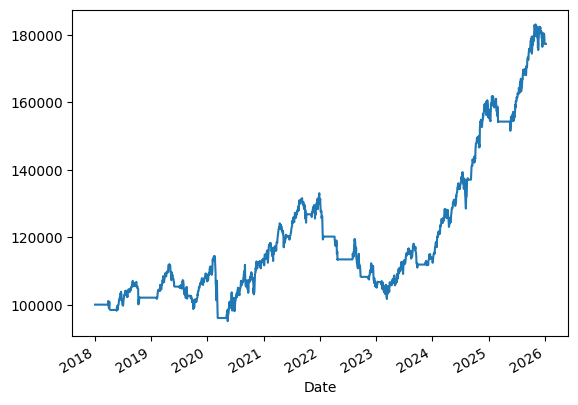

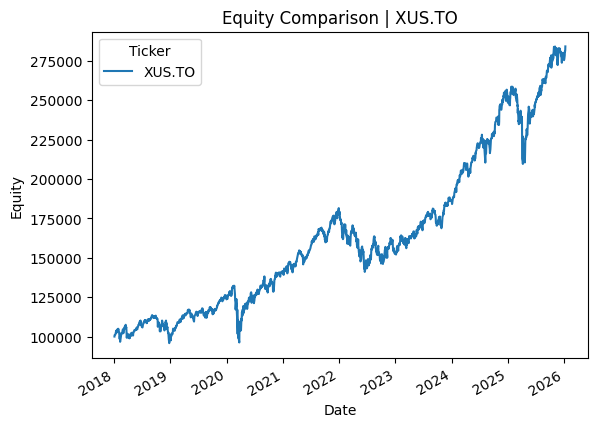

In [32]:
bh_equity = initial_cash * (1 + df["Close"].pct_change().fillna(0)).cumprod()
bh_equity.name = "Buy & Hold"

plt.figure()
bt["equity"].rename("SMA Strategy").plot()
bh_equity.plot()
plt.title(f"Equity Comparison | {ticker}")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.show()
